# Genetic Algorithm
This notebook takes you from absolute basics to a working **Genetic Algorithm (GA)** that evolves a random population of strings toward a target sentence.


## 0. Setup


In [ ]:
import random
import string
from typing import List, Tuple

# Optional: makes results repeatable while you're learning.
random.seed(42)


## 1. Define the Problem


### Key terms (simple):
- **Gene**: one character (e.g., `'H'`)
- **Chromosome / Individual**: one full string guess (e.g., `'HELXO WORPD'`)
- **Population**: many individuals (a list of strings)


In [ ]:
TARGET = "HELLO WORLD"
print("Target:", TARGET)
print("Length:", len(TARGET))


Target: HELLO WORLD
Length: 11


## 2. Gene Pool (Allowed Characters)

If a character is NOT in the gene pool, the algorithm can NEVER produce it.
Because our target includes a space, we must include `' '` (space).


In [ ]:
GENE_POOL = string.ascii_uppercase + " "
print("Gene pool:", GENE_POOL)
print("Gene pool size:", len(GENE_POOL))


Gene pool: ABCDEFGHIJKLMNOPQRSTUVWXYZ 
Gene pool size: 27


## 3. Make One Individual (Random Guess)

We create a function that generates one random string (individual) with the same length as the target.


In [ ]:
def make_individual(length: int) -> str:
    """Create ONE random individual (string) of a given length."""
    return "".join(random.choice(GENE_POOL) for _ in range(length))

one_guess = make_individual(len(TARGET))
print("One random guess:", one_guess)


One random guess: UDAXIHHEXDV


## 4. Make a Population

A **population** is just a list of individuals. We generate `pop_size` random guesses.


In [ ]:
def make_population(pop_size: int, target: str) -> List[str]:
    """Create a list of random individuals."""
    return [make_individual(len(target)) for _ in range(pop_size)]

population = make_population(pop_size=10, target=TARGET)
population


['XRCSNBACGHQ',
 'TARGWUWRNHO',
 'SIZAYZFWNKI',
 'EGYKDCMDLLT',
 'IZBXORDMCRJ',
 ' UTLSGWCBVH',
 'YJCHDMIOU L',
 'FLLGVIWVUCT',
 'UFRXHFOMIUW',
 'RHVK YYBH B']

## 5. Fitness Function (Scoring)

 **fitness = number of characters that match the target in the correct position**.



In [ ]:
def fitness(individual: str, target: str) -> int:
    """Count correct characters in the correct positions."""
    return sum(1 for a, b in zip(individual, target) if a == b)

# Demo: score a few
for indiv in population[:5]:
    print(indiv, "-> fitness:", fitness(indiv, TARGET))


XRCSNBACGHQ -> fitness: 0
TARGWUWRNHO -> fitness: 1
SIZAYZFWNKI -> fitness: 0
EGYKDCMDLLT -> fitness: 1
IZBXORDMCRJ -> fitness: 1


## 6. Ranking the Population



In [ ]:
def rank_population(population: List[str], target: str) -> List[Tuple[str, int]]:
    """Return (individual, fitness) pairs sorted best-to-worst."""
    scored = [(indiv, fitness(indiv, target)) for indiv in population]
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored

ranked = rank_population(population, TARGET)
ranked[:5]


[(' UTLSGWCBVH', 2),
 ('FLLGVIWVUCT', 2),
 ('TARGWUWRNHO', 1),
 ('EGYKDCMDLLT', 1),
 ('IZBXORDMCRJ', 1)]

## 7. Selection (Choosing Parents)

Selection decides who gets to reproduce.

**tournament selection**:
- Randomly pick `k` individuals
- The best among them wins and becomes a parent
- Repeat until you have enough parents


In [ ]:
def tournament_selection(population: List[str], target: str, k: int = 3) -> str:
    """Pick k random individuals and return the best among them."""
    contestants = random.sample(population, k)
    return max(contestants, key=lambda indiv: fitness(indiv, target))

# Demo: pick a few parents
parents = [tournament_selection(population, TARGET, k=3) for _ in range(5)]
parents


[' UTLSGWCBVH', ' UTLSGWCBVH', 'FLLGVIWVUCT', 'FLLGVIWVUCT', 'EGYKDCMDLLT']

## 8. Crossover

Crossover combines two parents to create a child.

**single-point crossover**:
- Choose a random cut point
- Child gets left part from parent1, right part from parent2


In [ ]:
def crossover(parent1: str, parent2: str) -> str:
    """Single-point crossover."""
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length.")
    if len(parent1) < 2:
        return parent1  # nothing to cross

    cut = random.randint(1, len(parent1) - 1)  # cut not at ends
    child = parent1[:cut] + parent2[cut:]
    return child

# Demo crossover
p1, p2 = parents[0], parents[1]
child = crossover(p1, p2)
print("Parent1:", p1)
print("Parent2:", p2)
print("Child:  ", child)


Parent1:  UTLSGWCBVH
Parent2:  UTLSGWCBVH
Child:    UTLSGWCBVH


## 9. Mutation (Small Random Changes)

We'll mutate each character with a small probability `mutation_rate`.
- If a gene mutates, we replace it with a random character from the gene pool.


In [ ]:
def mutate(individual: str, mutation_rate: float = 0.02) -> str:
    """Randomly change characters with probability mutation_rate."""
    chars = list(individual)
    for i in range(len(chars)):
        if random.random() < mutation_rate:
            chars[i] = random.choice(GENE_POOL)
    return "".join(chars)

# Demo mutation
example = "HELXO WORPD"
print("Before:", example)
print("After: ", mutate(example, mutation_rate=0.2))


Before: HELXO WORPD
After:  HELXPBWFRPM


## 10. Creating the Next Generation

1. **Keep** a few best individuals (elitism)
2. Fill the rest by:
   - selecting two parents
   - crossover
   - mutate the child


In [ ]:
def make_next_generation(
    population: List[str],
    target: str,
    elite_size: int = 2,
    tournament_k: int = 3,
    mutation_rate: float = 0.02,
) -> List[str]:
    ranked = rank_population(population, target)
    elites = [indiv for indiv, score in ranked[:elite_size]]

    new_population = elites.copy()
    while len(new_population) < len(population):
        parent1 = tournament_selection(population, target, k=tournament_k)
        parent2 = tournament_selection(population, target, k=tournament_k)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate=mutation_rate)
        new_population.append(child)

    return new_population

# Demo one generation step
pop2 = make_next_generation(population, TARGET, elite_size=2, tournament_k=3, mutation_rate=0.05)
rank_population(pop2, TARGET)[:5]


[(' UTLSGWCBVH', 2),
 ('FLLGVIWVUCT', 2),
 ('FLLGVXWVUHO', 2),
 ('FLLGVIWVUCT', 2),
 ('IZBXORDMCVH', 1)]

## 11. Full Genetic Algorithm Loop

run evolution for many generations until:
- we reach the exact target, OR
- we hit a max number of generations

track:
- best fitness each generation
- best individual each generation


In [ ]:
def run_ga(
    target: str,
    pop_size: int = 200,
    max_generations: int = 2000,
    elite_size: int = 5,
    tournament_k: int = 3,
    mutation_rate: float = 0.02,
) -> Tuple[str, List[int], List[str]]:
    population = make_population(pop_size, target)
    best_fitness_history: List[int] = []
    best_individual_history: List[str] = []

    for gen in range(1, max_generations + 1):
        ranked = rank_population(population, target)
        best_indiv, best_score = ranked[0]
        best_fitness_history.append(best_score)
        best_individual_history.append(best_indiv)

        # Print occasional progress
        if gen == 1 or gen % 50 == 0 or best_score == len(target):
            print(f"Gen {gen:4d} | best fitness {best_score:2d}/{len(target)} | {best_indiv}")

        if best_score == len(target):
            return best_indiv, best_fitness_history, best_individual_history

        population = make_next_generation(
            population,
            target,
            elite_size=elite_size,
            tournament_k=tournament_k,
            mutation_rate=mutation_rate,
        )

    # If not solved, return best at the end
    ranked = rank_population(population, target)
    return ranked[0][0], best_fitness_history, best_individual_history

best_solution, fitness_hist, best_hist = run_ga(
    target=TARGET,
    pop_size=200,
    max_generations=2000,
    elite_size=5,
    tournament_k=3,
    mutation_rate=0.03,
)

print("\nBest solution found:", best_solution)


Gen    1 | best fitness  3/11 | HUCU OWJUND
Gen   14 | best fitness 11/11 | HELLO WORLD

Best solution found: HELLO WORLD


## 12. Visualize Progress (Fitness Over Generations)


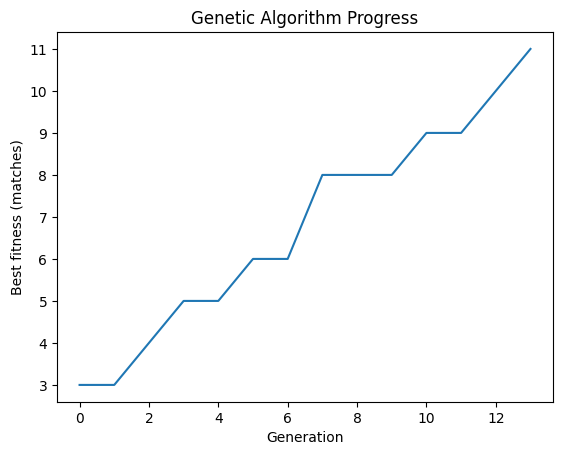

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fitness_hist)
plt.xlabel("Generation")
plt.ylabel("Best fitness (matches)")
plt.title("Genetic Algorithm Progress")
plt.show()
